# `Setup`

In [1]:
# Library Import
import pandas as pd
import numpy as np
import os
if os.getcwd().split('/')[-1] != 'aml_itu': os.chdir(os.path.abspath('.').split('aml_itu/')[0]+'aml_itu')
from utils.helpers import *
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont
import random
import time
from IPython.display import display, clear_output, Image as ipyImage
import cv2

# Printing current working directory
print(os.getcwd())

/Users/rasmuskrebs/Documents/School/semester_3/advanced_ml/aml_itu


### `Config`

In [2]:
# Loading the config file
config = load_config()
    
    
# Training Images
train_img = config['dataset']['images']['train']

# Outputting config    
config

{'dataset': {'name': 'state-farm-distracted-driver-detection',
  'colab_path': '/content/drive/MyDrive/aml-distracted-drivers-project',
  'data': '../state-farm-distracted-driver-detection/driver_imgs_list.csv',
  'images': {'train': '../state-farm-distracted-driver-detection/imgs/train',
   'test': '../state-farm-distracted-driver-detection/imgs/test'},
  'class_mapping': {'c0': 'safe driving',
   'c1': 'texting - right',
   'c2': 'talking on the phone - right',
   'c3': 'texting - left',
   'c4': 'talking on the phone - left',
   'c5': 'operating the radio',
   'c6': 'drinking',
   'c7': 'reaching behind',
   'c8': 'hair and makeup',
   'c9': 'talking to passenger'}},
 'outputs': {'path': './outputs'},
 'modeling_params': {'batch_size': 32, 'epochs': 100}}

In [3]:
# Loading the data
df = pd.read_csv(config['dataset']['data'])

In [4]:
config['dataset']['class_mapping']

{'c0': 'safe driving',
 'c1': 'texting - right',
 'c2': 'talking on the phone - right',
 'c3': 'texting - left',
 'c4': 'talking on the phone - left',
 'c5': 'operating the radio',
 'c6': 'drinking',
 'c7': 'reaching behind',
 'c8': 'hair and makeup',
 'c9': 'talking to passenger'}

## `Data Exploration`

In [5]:
df['target'] = df['classname'].map(config['dataset']['class_mapping'])

In [6]:
# class distribution  
df.target.value_counts(normalize=True)

safe driving                    0.110997
texting - left                  0.104620
talking on the phone - left     0.103728
drinking                        0.103684
talking on the phone - right    0.103327
operating the radio             0.103104
texting - right                 0.101097
talking to passenger            0.094943
reaching behind                 0.089279
hair and makeup                 0.085221
Name: target, dtype: float64

In [7]:
# Subject distribution
print('Total number of subjects in dataset: ', df.subject.nunique())
df.subject.value_counts(normalize=True)

Total number of subjects in dataset:  26


p021    0.055164
p022    0.054986
p024    0.054674
p026    0.053336
p016    0.048073
p066    0.046111
p049    0.045086
p051    0.041027
p014    0.039065
p015    0.039021
p035    0.037817
p047    0.037237
p081    0.036702
p012    0.036702
p064    0.036568
p075    0.036300
p061    0.036077
p056    0.035408
p050    0.035230
p052    0.033000
p002    0.032331
p045    0.032287
p039    0.029031
p041    0.026980
p042    0.026356
p072    0.015430
Name: subject, dtype: float64

#### `Visualizing Images`

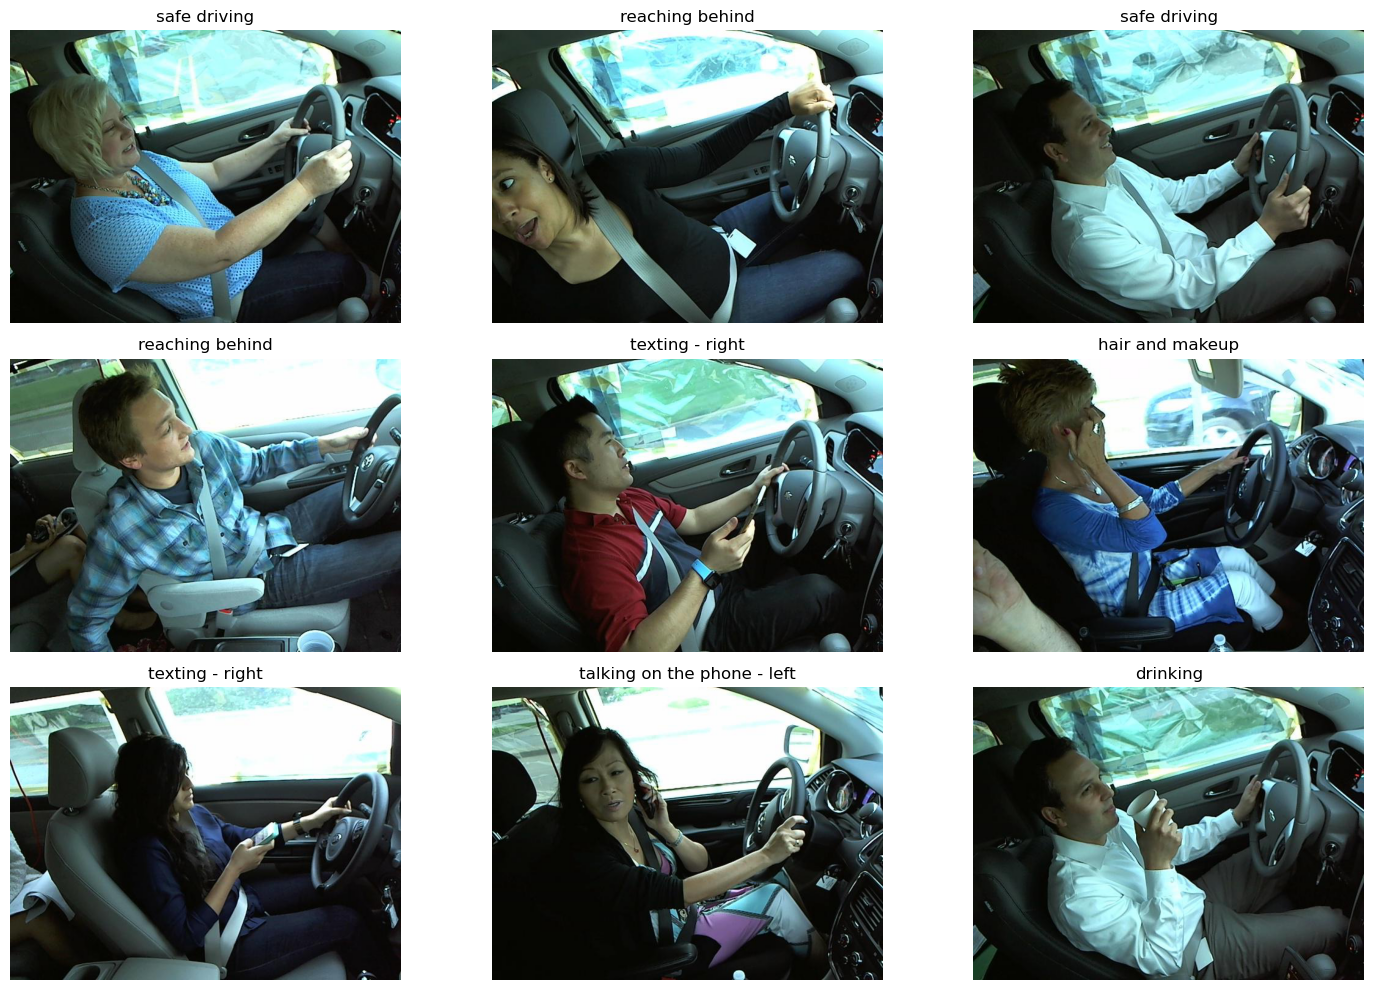

In [9]:
# Generate random list of indexs
random_list = random.sample(range(0, len(df)), 9)

# Plotting the images
fig, axes = plt.subplots(3, 3, figsize=(15, 10))
for i, ax in enumerate(axes.flat):
    img = Image.open(os.path.join(train_img, df.iloc[random_list[i]].classname, df.iloc[random_list[i]].img))
    ax.imshow(img)
    ax.set_title(df.iloc[random_list[i]].target)
    ax.axis('off')
fig.tight_layout()

In [13]:
# Importing random image as numpy array
img = Image.open(os.path.join(train_img, df.iloc[random_list[0]].classname, df.iloc[random_list[0]].img))

# Transforming the image to numpy array
img = np.array(img)

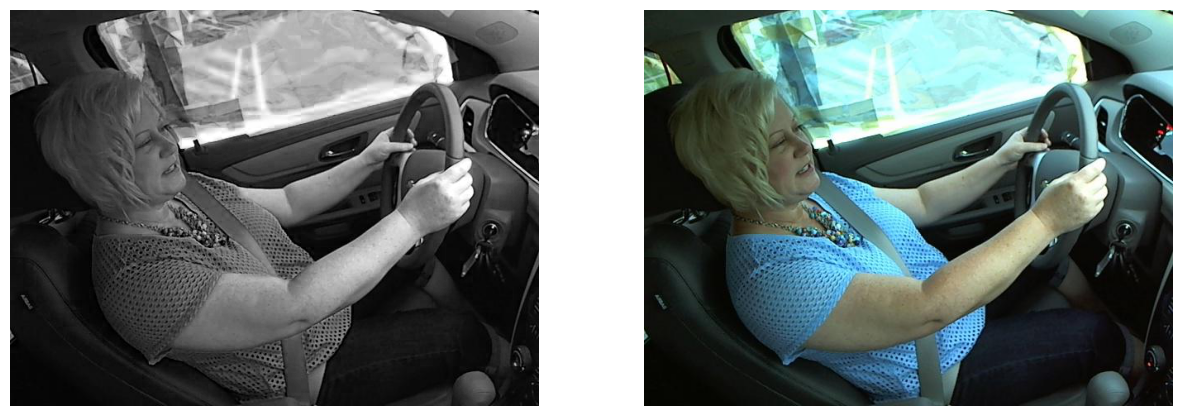

In [14]:
# Plotting grey version and colored
fig, axes = plt.subplots(1, 2, figsize=(15, 18))
for i, ax in enumerate(axes.flat):
    if i == 0:
        ax.imshow(img[:,:,i], cmap='gray')
    else:
        ax.imshow(img)
    ax.axis('off')

#### `Ìmage Segmentation by Clustering`

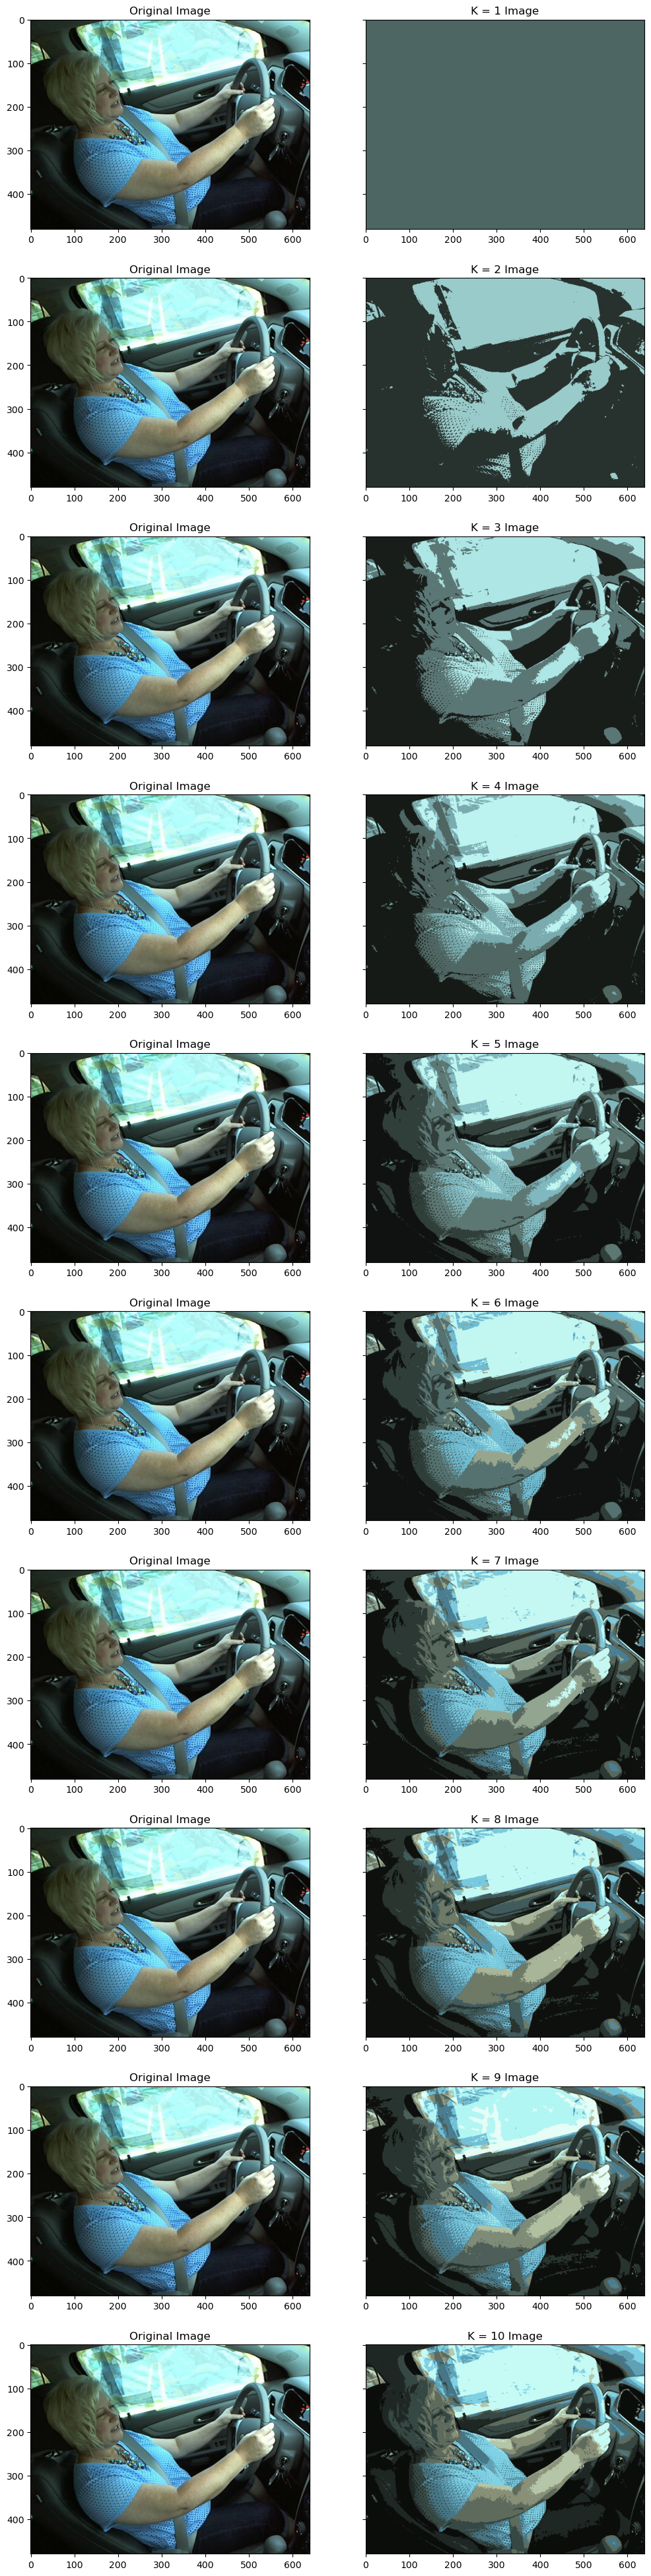

In [16]:
# This code is copied from here: https://www.geeksforgeeks.org/image-segmentation-by-clustering/

# Kmeans Clustering of pixels
plt.rcParams["figure.figsize"] = (12,50) 
  
# load image 
Z = img.reshape((-1,3)) 
# convert to np.float32 
Z = np.float32(Z) 
  
# define stopping criteria, number of clusters(K) and apply kmeans() 
# TERM_CRITERIA_EPS : stop when the epsilon value is reached 
# TERM_CRITERIA_MAX_ITER:  stop when Max iteration is reached 
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0) 
  
fig, ax = plt.subplots(10,2, sharey=True) 
for i in range(10): 
  K = i+1
  # apply K-means algorithm 
  ret,label,center=cv2.kmeans(Z,K,None,criteria,attempts = 10, 
                             flags=cv2.KMEANS_RANDOM_CENTERS) 
  # Now convert back into uint8, and make original image 
  center = np.uint8(center) 
  res = center[label.flatten()] 
  res2 = res.reshape((img.shape)) 
  # plot the original image and K-means image 
  ax[i, 1].imshow(res2) 
  ax[i,1].set_title('K = %s Image'%K) 
  ax[i, 0].imshow(img, ) 
  ax[i,0].set_title('Original Image') 

#### `Determining Appropriate Train/Test Split`
We want an appropriate dataset split, but rather than randomly splitting 80/20 for all images, we will try to extract around 20% of subjects that together should also accumlate to approxiamtely 20% of all images in the dataset. This way, for our validation, we won't have the same subjects appear, and rather we'll see if our model generalizes well onto unseen subjects

In [41]:
# Determing approximately how many images needs to be in test set
test_size = int(len(df) *.2)
print('Number of test images should amount to: ', test_size)

# Determing approximately how many subjects are in 20%
print('Number of test subject should amount to:',  int(df.subject.nunique()*.2))

Number of test images should amount to:  4484
Number of test subject should amount to: 5


In [42]:
# Determing count of images per subject
subject_count = df.groupby('subject').agg(count=('img','count')).sort_values(by='count', ascending=False).reset_index()
subject_count

subject  count
0     p021   1237
1     p022   1233
2     p024   1226
3     p026   1196
4     p016   1078
5     p066   1034
6     p049   1011
7     p051    920
8     p014    876
9     p015    875
10    p035    848
11    p047    835
12    p081    823
13    p012    823
14    p064    820
15    p075    814
16    p061    809
17    p056    794
18    p050    790
19    p052    740
20    p002    725
21    p045    724
22    p039    651
23    p041    605
24    p042    591
25    p072    346

In [43]:
# Computing +/- 2 images per subject to get sum over 5 subjects
subject_count['sum_column'] = subject_count['count'] + subject_count['count'].shift(1) + subject_count['count'].shift(-1) + subject_count['count'].shift(2) + subject_count['count'].shift(-2)

In [68]:
# Finding subjects within range
subject_count[(subject_count.sum_column <= test_size)].head(1)

subject  count  sum_column
9    p015    875      4354.0

In [74]:
# list of subjects to be in test set
subjects = subject_count.iloc[9-2:9+3, 0].to_list()
subjects

['p051', 'p014', 'p015', 'p035', 'p047']

In [89]:
# Ensuring sufficient label distribution
print('Test set label distribution')
print(df[df.subject.isin(subjects)].target.value_counts(normalize=True))

print('\nTrain set label distribution')
print(df[-df.subject.isin(subjects)].target.value_counts(normalize=True))

Test set label distribution
safe driving                    0.122876
drinking                        0.107947
operating the radio             0.106109
talking on the phone - left     0.104731
texting - left                  0.103813
texting - right                 0.101286
talking on the phone - right    0.100597
reaching behind                 0.093477
talking to passenger            0.084750
hair and makeup                 0.074414
Name: target, dtype: float64

Train set label distribution
safe driving                    0.108135
texting - left                  0.104815
talking on the phone - right    0.103985
talking on the phone - left     0.103486
drinking                        0.102656
operating the radio             0.102380
texting - right                 0.101051
talking to passenger            0.097399
reaching behind                 0.088268
hair and makeup                 0.087825
Name: target, dtype: float64


#### `Subject Gif`
Only used to generate gif in `outputs/`

In [ ]:
# Plotttig all subject images

# Getting subject with least number of pictures
subject = df[df.subject == df.subject.value_counts().index[0]].groupby('target').head(25)
subject.sort_values(by='classname',ascending=False, inplace=True)

In [ ]:
# Creating a list of paths for one subject
frames = []
targets = []
for ind in subject.index:
    d = subject.loc[ind]
    frames.append(os.path.join(train_img, d.classname, d.img))
    targets.append(os.path.join(d.target))

In [ ]:
def display_images_as_gif(images, targets, delay=0.1):
    # Loop throung images in path
    for image_path, target in zip(images, targets):
        # open image using PIL
        with Image.open(image_path) as img:
            draw = ImageDraw.Draw(img)
            draw.text((320, 10), target, fill=(255, 0, 0), 
                      stroke_width=1, 
                      font=ImageFont.truetype("/System/Library/Fonts/Helvetica.ttc", 35),
                      anchor='mt'
                      )
            # Display image
            display(img)
            # Pause for delay
            time.sleep(delay)
            # Clear output to make sure only one image is displayed, but wait for new image to be displayed
            clear_output(wait=True)

In [ ]:
# Viewing gif   
display_images_as_gif(frames, targets, delay=0.001)

In [ ]:
# Generating gif for all targets
def create_gif(image_files, targets, output_file, duration=100):
    # List of images to be used in gif
    image_out = [] 

    # Loop throung images
    for file, target in zip(image_files, targets):
        # open image using PIL
        with Image.open(file) as img:
            # Add targets to images
            draw = ImageDraw.Draw(img)
            
            # Adding target name
            draw.text((320, 10), target, fill=(255, 0, 0), 
                      stroke_width=1, 
                      font=ImageFont.truetype("/System/Library/Fonts/Helvetica.ttc", 35),
                      anchor='mt'
                      )
            
            # Appending image to output list
            image_out.append(img)
    
    # Set the duration for each frame (in milliseconds)
    for image in image_out:
        image.info['duration'] = duration

    # Save output
    image_out[0].save(output_file, save_all=True, append_images=image_out[1:], loop=0)

    return

In [ ]:
# Specifying output name
output_name = f"{config['outputs']['path']}/targets.gif"

# Generating gif
create_gif(frames, targets, output_name, duration=100)

In [ ]:
# Display the gif from output folder
display(ipyImage(filename=output_name))